In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pandasgui import show
import matplotlib.ticker as ticker

In [5]:
df = pd.read_pickle("../nas_pickle/acc_0.98_util_0.02_hl_4_10_40.pkl")

#df.groupby('hash').first().nsmallest(40, 'fitness')

In [16]:
# Check if the mutation problem still exists.

for gen in df["gen"].unique():
    if gen == 0:
        continue
    
    prev_gen = df[df["gen"] == gen - 1]
    current_gen = df[df["gen"] == gen]

    for md5 in current_gen["hash"].unique():
        current_gen_hashes = len(current_gen[current_gen["hash"] == md5])
        prev_gen_hashes = len(prev_gen[prev_gen["hash"] == md5])
        #print(f"Current Gen Hashes: {current_gen_hashes}\tPrevious Gen Hashes: {prev_gen_hashes}")
        if (current_gen_hashes > 1) and (prev_gen_hashes == 0):
            print(f"Heuston, we have a problem. Hash: {md5}")

Heuston, we have a problem. Hash: aeaff8f167ea7abb7e9a58c3f5d3a7fc


In [6]:
def validate(df):
        # Ensure architectures with the same hash have the same parameters.
        def hash_validate(df_group):
            rows_valid = df_group.eq(df_group.iloc[0]).all(axis=1).all()
            if not rows_valid:
                raise(ValueError(f"Hash {df_group['hash'].iloc[0]} contains different architectures!"))

        df.groupby("hash").apply(hash_validate)

        # Ensure dataframe is maintaining a consistent index.
        if not df.index.is_unique:
            raise(ValueError(f"Index values are not unique!"))
        
#validate(df)

In [9]:
df = pd.read_pickle("../nas_pickle/acc_0.98_util_0.02_hl_4_10_40.pkl")
# df.groupby('hash').apply(validate)

In [10]:
def serialise_params(pd_obj):
    serial_list = pd_obj["hidden_layers"] + pd_obj["inter_layer_bitwidth"] + pd_obj["inter_layer_fanin"]
    return serial_list

# Function to calculate variance of list-like elements in a series
def convergence(df):
    vals = []
    for i in range(df['gen'].max() + 1):
        gen_df = df[df['gen'] == i]
        matrix = []
        for j in range(len(gen_df)):
            matrix.append(serialise_params(gen_df.iloc[j]))
        np_matrix = np.array(matrix)
        std_dev = np.std(np_matrix, axis=0)
        cv = (std_dev / np.mean(np_matrix, axis=0))
        vals.append(np.mean(cv))

    return vals

generation_stats = df.groupby('gen')['fitness'].agg(['min', 'mean']).reset_index()
generation_stats["convergence"] = convergence(df)

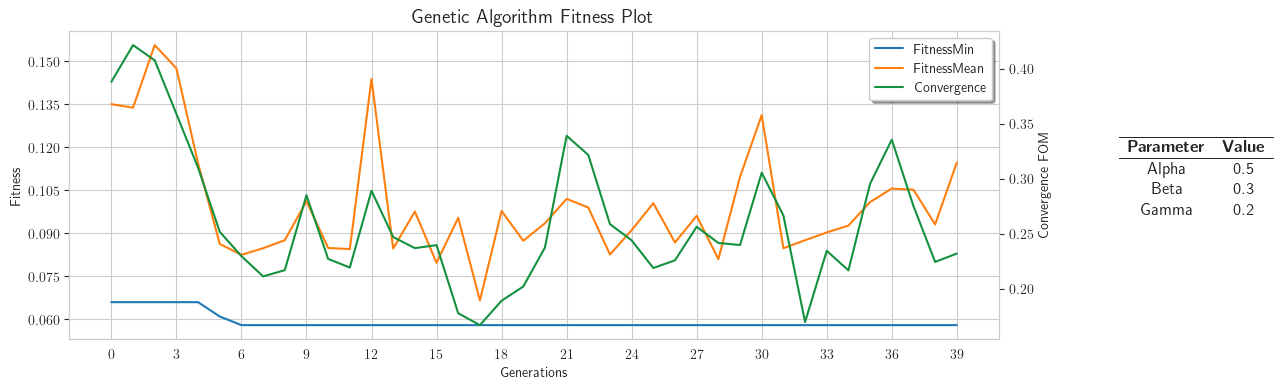

In [47]:
import os
# Replace "/path/to/latex/bin" with the actual path to your LaTeX bin directory
os.environ["PATH"] += os.pathsep + 'C:/Users/Peter/AppData/Local/Programs/MiKTeX/miktex/bin/x64'

sns.set_style('whitegrid')
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'')

fig, ax1 = plt.subplots(figsize=(12, 4))

ln1 = ax1.plot(generation_stats[['min', 'mean']], label=['FitnessMin', 'FitnessMean'])
ax1.set_xlabel("Generations")
ax1.set_ylabel("Fitness")
ax1.set_title("Genetic Algorithm Fitness Plot", fontsize=14)
ax2 = plt.twinx(ax1)
ln2 = ax2.plot(generation_stats['convergence'], color="#14913E", label="Convergence")
ax2.tick_params(axis='y')
ax2.set_ylabel("Convergence FOM")

ax1.yaxis.set_major_locator(ticker.MaxNLocator(10))
ax1.xaxis.set_major_locator(ticker.MaxNLocator(16))
ax2.grid(None)

# Create a single, shared legend
lns = ln1 + ln2
labels = [l.get_label() for l in lns]
ax1.legend(lns, labels, loc='upper right', fancybox=True, shadow=True, ncol=1)

latex_table = (
r"\begin{tabular}{cc}"
r"\hline "
r"\textbf{Parameter} & \textbf{Value} \\"
r"\hline "
r"Alpha & 0.5 \\"
r"Beta & 0.3 \\"
r"Gamma & 0.2"
r"\end{tabular}")

# Display the LaTeX table in the figure
plt.figtext(1, 0.5, latex_table, fontsize=12, ha='left')

transform=ax1.transAxes

parameters = [['Learning rate', '0.01'], 
              ['Epochs', '100'], 
              ['Batch size', '32'],
              ['Optimizer', 'Adam']]

Text(0.5, 1.0, '\\TeX\\ is Number $\\displaystyle\\sum_{n=1}^\\infty\\frac{-e^{i\\pi}}{2^n}$!')

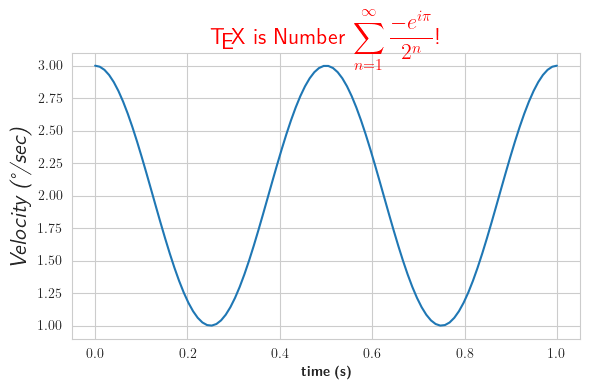

In [14]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['text.usetex'] = True


t = np.linspace(0.0, 1.0, 100)
s = np.cos(4 * np.pi * t) + 2

fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
ax.plot(t, s)

ax.set_xlabel(r'\textbf{time (s)}')
ax.set_ylabel('\\textit{Velocity (\N{DEGREE SIGN}/sec)}', fontsize=16)
ax.set_title(r'\TeX\ is Number $\displaystyle\sum_{n=1}^\infty'
             r'\frac{-e^{i\pi}}{2^n}$!', fontsize=16, color='r')